# Problem 1.1.1

In [786]:
import xml.etree.ElementTree as ET
import numpy as np

# setup
fp = "data/VOCdevkit/VOC2012/Annotations/2007_000027.xml"

def parse_file(fp):    
    # extract xml tree
    tree = ET.parse(fp)
    root = tree.getroot()

    # identify objects
    # extract boundary box data
    output = []
    for obj in root.findall("./object"):
        name = obj.find("name").text
        box = obj.find("bndbox")
        x = int(box.find("xmin").text)
        xmax = int(box.find("xmax").text)
        y = int(box.find("ymin").text)
        ymax = int(box.find("ymax").text)
        
        w = xmax - x
        h = ymax - y
        
        coords = [name, x, y, w, h]
        output.append(coords)

    # put in numpy array format 
    output = np.array(output)
    
    return(output)

# Problem 1.1.2

In [787]:
import matplotlib.pyplot as plt
from matplotlib import patches
from PIL import Image

xml_path = "data/VOCdevkit/VOC2012/Annotations/2007_000027.xml"
img_path = "data/VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg"

def show_image(img_path, xml_path):
    # load image
    # load xml file
    img = Image.open(img_path)
    bndbox = parse_file(xml_path)
    
    # make figure
    fig, ax = plt.subplots()
    ax.imshow(img)
    
    # make boxes
    for obj in bndbox:
        box = patches.Rectangle((int(obj[1]), int(obj[2])), int(obj[3]), int(obj[4]), 
                                linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(box)


# Problem 1.3

In [788]:
# generate training dataset
# load training images
# load ground truth boxes
# generate anchor points (N_anchors = feature_map_w * feature_map_y)
# generate proposed boxes
# subset to boxes in image
# Calculate IoU for boxes
# Label proposed boxes (sub-0.3 -> 0; 0.7+ -> 1; else, -1)
# subset out label=-1 boxes


# build model

# train model

# do non-maximum suppression

# Problem 2

In [789]:
print("Loading libraries...")
from imagecorruptions import corrupt, get_corruption_names
from PIL import Image
import matplotlib.pyplot as plt
import os
import cv2
from time import time
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import numpy as np
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# setup
print("Setting up images filepaths...")
corr_names = get_corruption_names()
folder_path = "data/VOCdevkit/VOC2012/JPEGImages/"

img_paths = [os.path.join(folder_path, img_path) for img_path in os.listdir(folder_path)]
random.shuffle(img_paths)
partition = int(0.8 * len(img_paths))
train_paths = img_paths[:partition]
val_paths = img_paths[partition:]

print("Defining corruption function...")
# generate corrupted datasets
def corrupt_set(img_paths):
    start = time()
    imgs_final = []
    i = 1
    for img_path in img_paths:
        print(f"Corrupting image {i} of {len(img_paths)}...", end="\r")
        # load image
        # resize image
        img = np.array(Image.open(img_path))
        img = cv2.resize(img, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

        # generate corruptions
        # add to larger dataset
        #for corr_name in corr_names:
        for sev in range(1,6):
            img_noised = corrupt(img, corruption_name="gaussian_noise", severity=sev)
            img_pair = np.stack([img_noised, img], axis=3)
            imgs_final.append(img_pair)
        i += 1
    # print(time() - start)
    return(imgs_final)

print("Corrupting images...")
train_paths_part = np.array_split(train_paths, len(train_paths) // 320)
val_paths_part = np.array_split(val_paths, len(val_paths) // 320)

# i = 1
# for partition in train_paths_part:
#     print(f"Saving training set {i} of {len(train_paths) // 320}", end="\r")
#     train_corrupt = corrupt_set(partition)
#     np.save(f"training_data/train_imgs_{i}.npy", train_corrupt)
#     i += 1

# i = 1
# for partition in val_paths_part:
#     print(f"Saving validation set {i} of {len(val_paths) // 320}", end="\r")
#     val_corrupt = corrupt_set(partition)
#     np.save(f"val_data/val_imgs_{i}.npy", val_corrupt)
#     i += 1

# train_final = corrupt_set(train_paths)
# val_final = corrupt_set(val_paths)

# save dataset
# np.save("train_imgs.npy", train_final)
# np.save("val_imgs.npy", val_final)
print("Images saved!")

Loading libraries...
Setting up images filepaths...
Defining corruption function...
Corrupting images...
Images saved!


In [790]:
# define image data class

class ImgData:
    def __init__(self, fp):
        # load dataset
        # reshape dataset
        data = np.load(fp).transpose(0,3,1,2,4)
        
        # split into corrupted, original images
        # convert to pytorch tensors
        self.corrupted = torch.from_numpy(data[:,:,:,:,0]).to(torch.float32)
        self.orig = torch.from_numpy(data[:,:,:,:,1]).to(torch.float32)
        
    def __len__(self):
        return len(self.corrupted)

    def __getitem__(self, rownum):
        corrupted = self.corrupted[rownum, :, :, :]
        orig = self.orig[rownum, :, :, :]
        return corrupted, orig
    

In [863]:
# define autoencoder model class

class CorruptioNet(nn.Module):
    def __init__(self):
        super(CorruptioNet, self).__init__()
        
        self.Encoder = nn.Sequential(
            nn.Conv2d(3, 16*3, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(16*3, 8*3, 3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Dropout(0.5)
        )
        
        self.Decoder = nn.Sequential(
            nn.ConvTranspose2d(8*3, 3, 3, stride=1, padding=1),
            nn.BatchNorm2d(3),
            nn.Sigmoid(),
        )
        
        self.c1 = nn.ConvTranspose2d(3, 3, 1, stride=1)
        self.a1 = nn.Sigmoid()
        self.bn1 = nn.BatchNorm2d(3)
        
    def Decoder2(self, x, x_old):
        x = self.c1(x + x_old)
        x = self.bn1(x)
        x = self.a1(x)
        return(x)
    
    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        x = self.Decoder2(x, x_old)
        x = torch.round(x * 255) # rescaling to RGB range
        return x

In [864]:
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=1)
_, (corr, _) = next(enumerate(val_loader))
model = CorruptioNet()
print(corr.shape)
print(model.Encoder(corr).shape)
out = model(corr)
print(out.shape)

torch.Size([1, 3, 64, 64])
torch.Size([1, 24, 64, 64])
torch.Size([1, 3, 64, 64])


In [865]:
# define training function

def train_model(model, data, val_data, epochs):
    start = time()
    
    # define loss function
    # set optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
    
    model = model.to(device)

    # set up data loader
    N_train = 64
    train_loader = torch.utils.data.DataLoader(data, shuffle=True, batch_size=N_train)
    val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=16)
    
    # run training loop
    losses = []
    val_losses = []
    for epoch in range(epochs):
        i = 0
        for batch_id, (corrupted, orig) in enumerate(train_loader):
            corrupted = corrupted.to(device)
            orig = orig.to(device)
            
            # training loss + gradient descent
            print(f"""Epoch {epoch}, batch {batch_id}/{len(train_loader)}""", end="\r")
            model.train()
            optimizer.zero_grad()
            out_image = model(corrupted)
            loss = criterion(orig, out_image)
            loss.backward()
            optimizer.step()
            losses.append([epoch, batch_id, loss.item()/N_train])
            
            # validation loss
            model.eval()
            val_loss = 0
            N = 0
            with torch.no_grad():
                for _, (corr, orig2) in enumerate(val_loader):
                    corr = corr.to(device)
                    orig2 = orig2.to(device)
                    
                    N_batch = corr.size(0)
                    N += N_batch
                    denoised = model(corr)
                    loss = criterion(denoised, orig2)
                    val_loss += loss.item()
                    break
            val_loss = val_loss/N
            val_losses.append([epoch, batch_id, val_loss])
            
            # set training stop
            # if i > 16:
            #     break
            # else:
            #     i += 1

    print(time() - start)
    return model, losses, val_losses

Training set 1 of 42
8.600461721420288/26


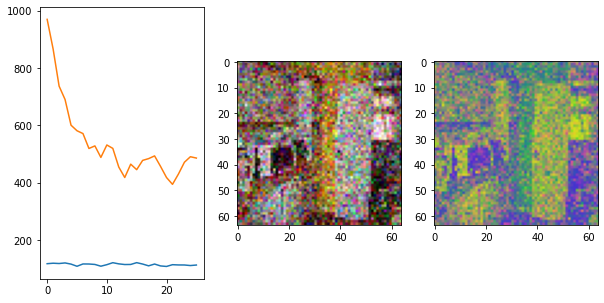

Training set 2 of 42
8.952905893325806/26


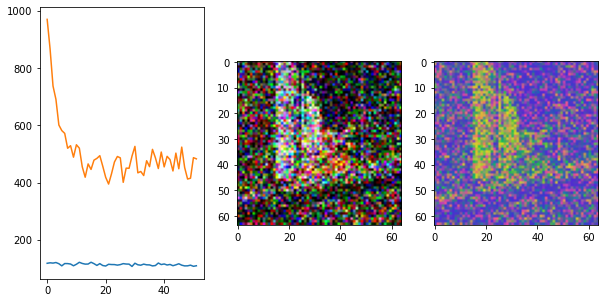

Training set 3 of 42
8.698972702026367/26


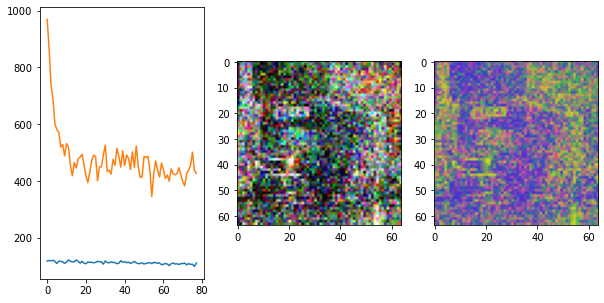

Training set 4 of 42
9.347553491592407/26


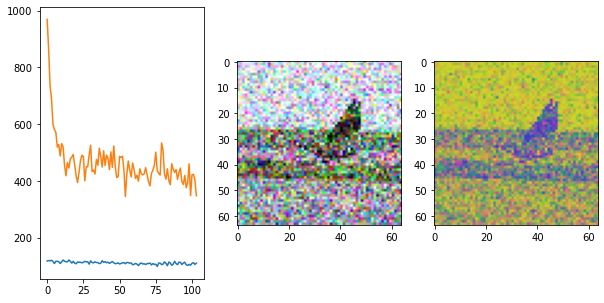

Training set 5 of 42
8.789740800857544/26


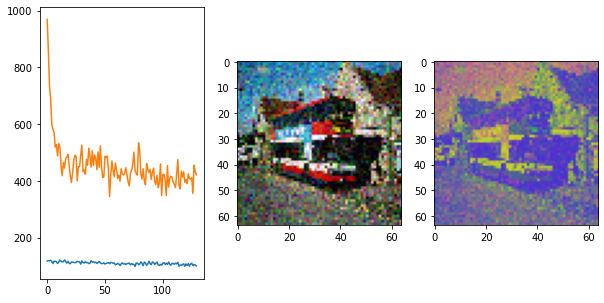

Training set 6 of 42
8.796212196350098/26


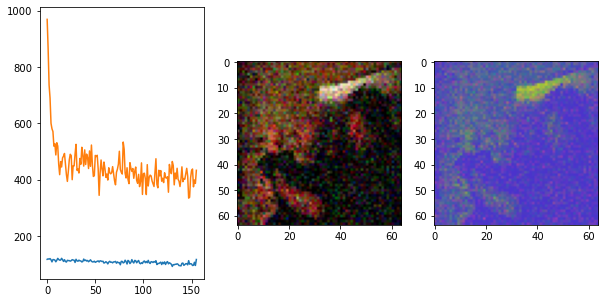

Training set 7 of 42
8.760813951492315/26


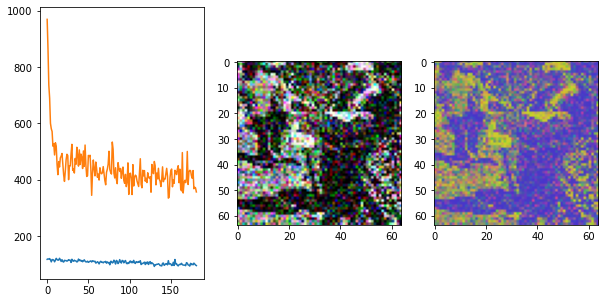

Training set 8 of 42
8.918125867843628/26


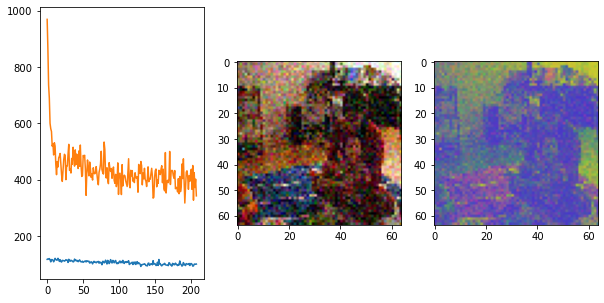

Training set 9 of 42
8.716078996658325/26


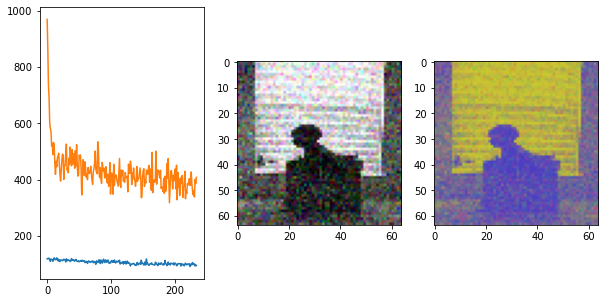

Training set 10 of 42
8.346712350845337/26


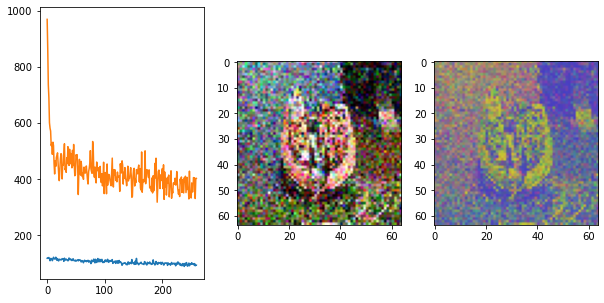

Training set 11 of 42
8.414075613021855/26


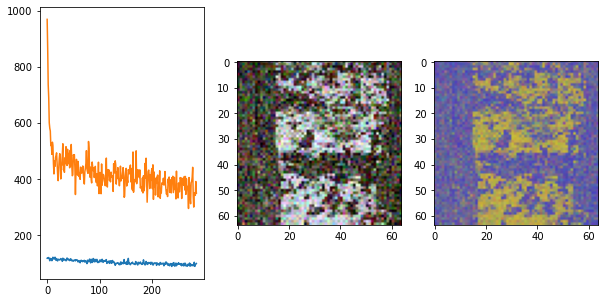

Training set 12 of 42
9.000719785690308/26


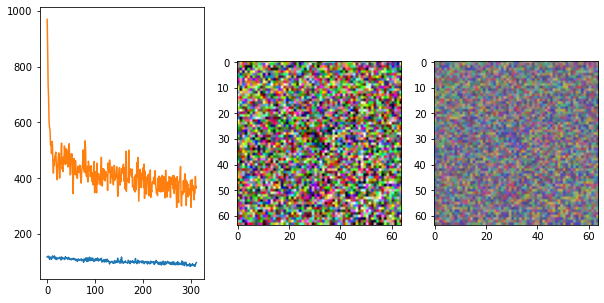

Training set 13 of 42
10.10674524307251/26


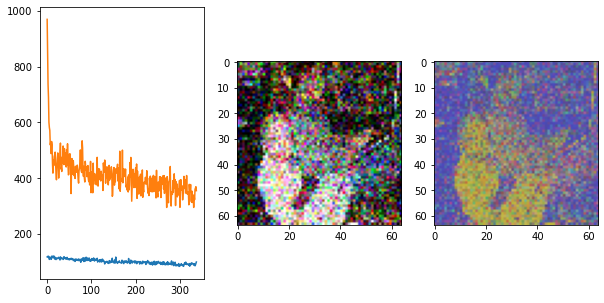

Training set 14 of 42
8.790491342544556/26


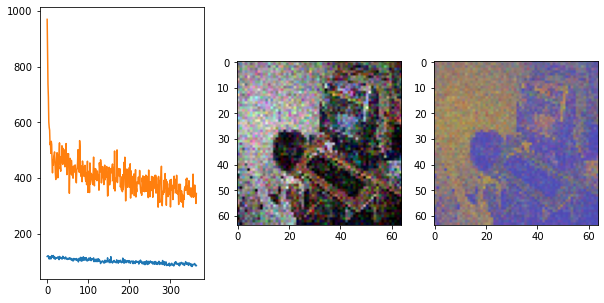

Training set 15 of 42
9.170833349227905/26


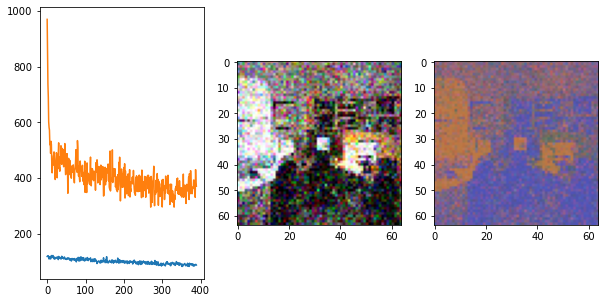

Training set 16 of 42
8.588206768035889/26


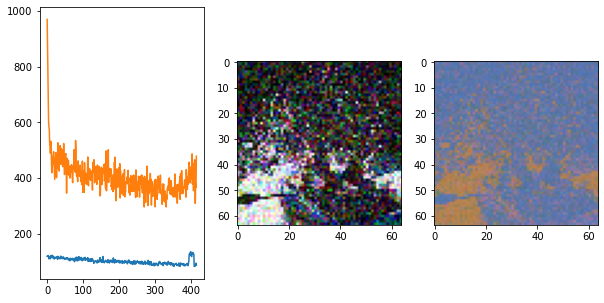

Training set 17 of 42
8.884761095046997/26


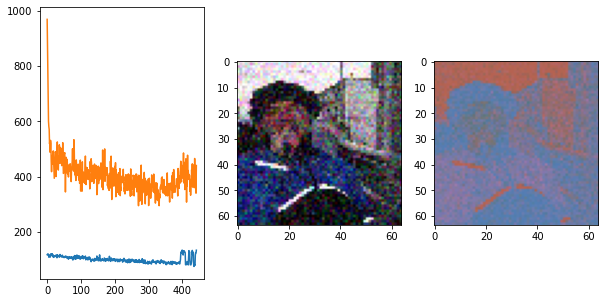

Training set 18 of 42
8.990522861480713/26


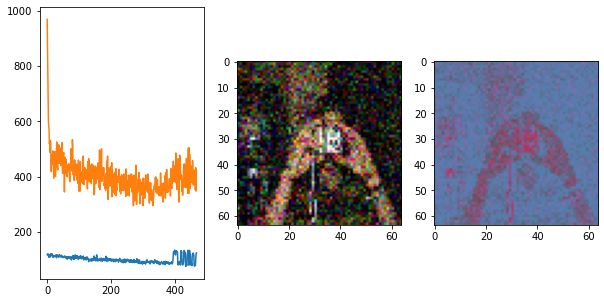

Training set 19 of 42
8.477813482284546/26


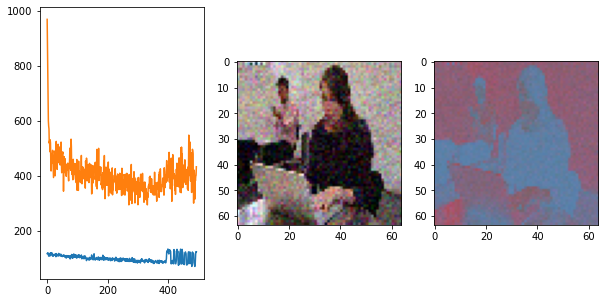

Training set 20 of 42
8.964941501617432/26


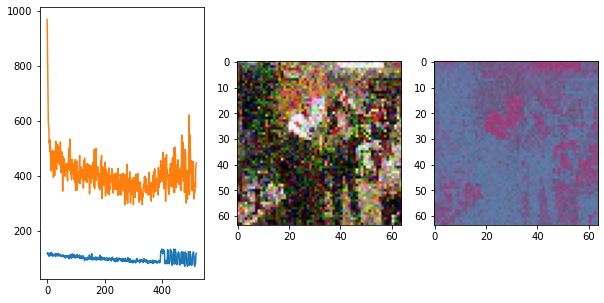

Training set 21 of 42
8.870940923690796/26


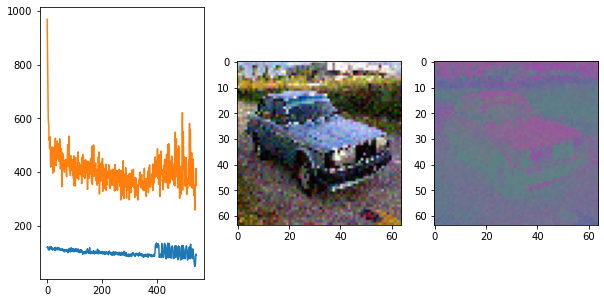

Training set 22 of 42
8.808521270751953/26


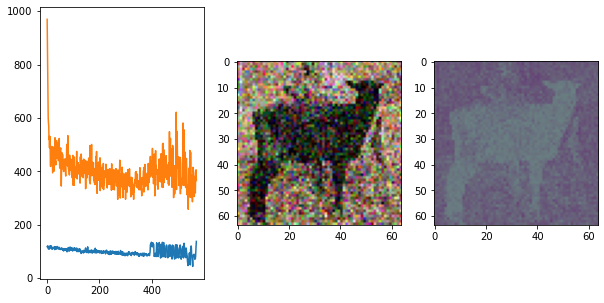

Training set 23 of 42
9.003363609313965/26


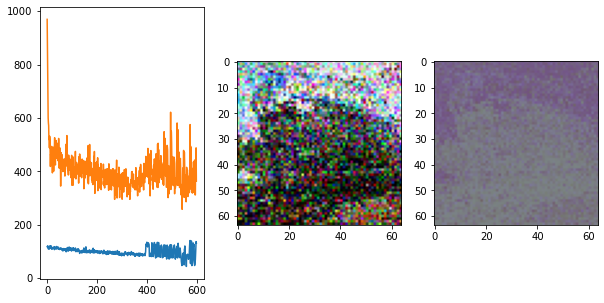

Training set 24 of 42
8.714701175689697/26


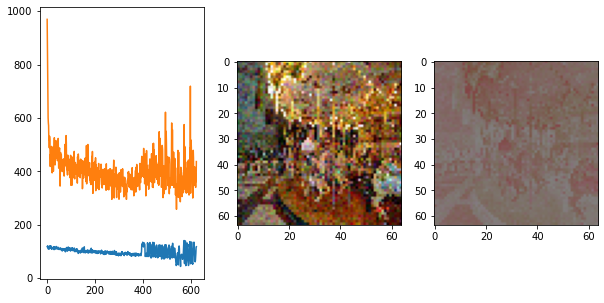

Training set 25 of 42
9.118324279785156/26


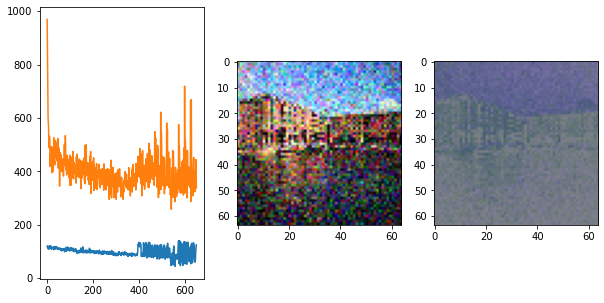

Training set 26 of 42
8.138637065887451/26


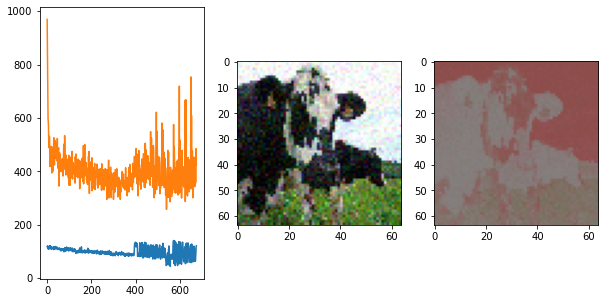

Training set 27 of 42
8.796442508697515/26


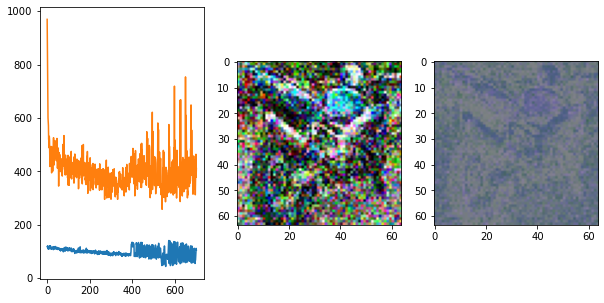

Training set 28 of 42
8.721858024597168/26


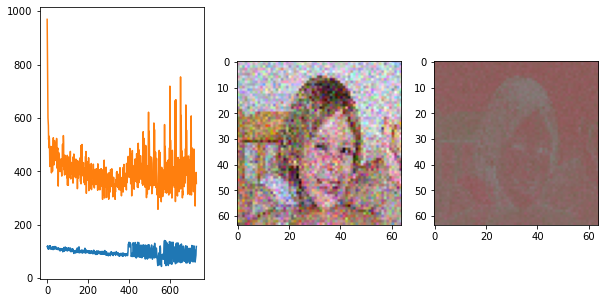

Training set 29 of 42


KeyboardInterrupt: 

In [866]:
batch_path = "training_data"
train_batches = [os.path.join(batch_path, data_path) for data_path in os.listdir(batch_path)]
# train_batches = ["train_imgs.npy"]

# loop through training data
# train models

model = CorruptioNet()
#model.load_state_dict(torch.load('autoencoder64.pth'))
#print("Model loaded!")

i = 1
val = ImgData("val_imgs.npy")
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=1)
for batch_fp in train_batches:
    batch = ImgData(batch_fp)
    if i > 1:
        model.load_state_dict(torch.load('autoencoder64.pth'))
    
    print(f"Training set {i} of {len(train_batches)}")
    model, losses, val_losses = train_model(model, batch, val, 1)
    torch.save(model.state_dict(), 'autoencoder64.pth')
    
    losses = np.array(losses)
    val_losses = np.array(val_losses)
    if i == 1:
        loss_combo = np.hstack((losses, val_losses[:,2].reshape(-1, 1)))
        loss = np.array(loss_combo)
    else:
        losses[:,1] = losses[:,1] + max(loss[:,1]) + 1
        loss_combo = np.hstack((losses, val_losses[:,2].reshape(-1, 1)))
        loss = np.concatenate([loss, loss_combo])
    
    fig, ax = plt.subplots(1,3,figsize=(10,5))
    ax[0].plot(loss[:,1], loss[:,2], marker='', label="training")
    ax[0].plot(loss[:,1], loss[:,3], marker='', label="validation")

    _, (img, _) = next(enumerate(val_loader))
    img_denoised = model(img)
    img = img.permute(0,2,3,1).int()
    img_denoised = img_denoised.permute(0,2,3,1).int()
    ax[1].imshow(img[0,:,:,:].detach().numpy())
    ax[2].imshow(img_denoised[0,:,:,:].detach().numpy())
    plt.show()

    # if i >= 15:
    #     break
    # else:
    #     i += 1
    i += 1

print("Training complete!")

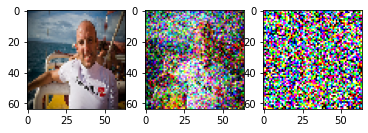

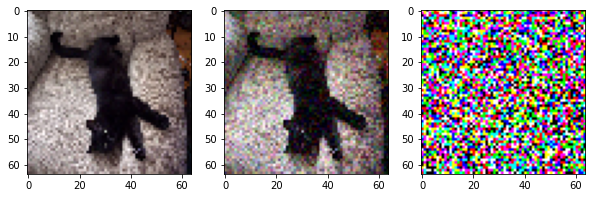

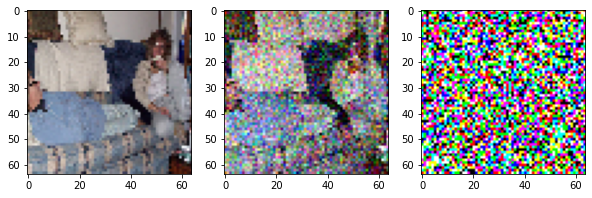

In [795]:
# batch_path = "val_data"
# train_batches = [os.path.join(batch_path, data_path) for data_path in os.listdir(batch_path)]
train_batches = ["val_imgs.npy"]
model = CorruptioNet()
model.load_state_dict(torch.load('autoencoder64.pth'))
val = ImgData(train_batches[0])
val_loader = torch.utils.data.DataLoader(val, shuffle=True, batch_size=32)

_, (img_noised, img) = next(enumerate(val_loader))
img_new = model(img_noised)

img = img.permute(0,2,3,1).int()
img_noised = img_noised.permute(0,2,3,1).int()
img_new = img_new.permute(0,2,3,1).int()

fig, ax = plt.subplots(1,3)
ax[0].imshow(img[0,:,:,:].detach().numpy())
ax[1].imshow(img_noised[0,:,:,:].numpy())
ax[2].imshow(img_new[0,:,:,:].detach().numpy())

fig, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(img[1,:,:,:].detach().numpy())
ax[1].imshow(img_noised[1,:,:,:].numpy())
ax[2].imshow(img_new[1,:,:,:].detach().numpy())

fig, ax = plt.subplots(1,3,figsize=(10,5))
ax[0].imshow(img[2,:,:,:].detach().numpy())
ax[1].imshow(img_noised[2,:,:,:].numpy())
ax[2].imshow(img_new[2,:,:,:].detach().numpy())

In [796]:
print(len(train_batches))

1
